In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib

class ModelTrainer:
    def __init__(self, model, encoder=None):
        self.model = model
        self.encoder = encoder if encoder else OneHotEncoder(sparse_output=False)

    def prepare_data(self, df, features, targets):
        X = df[features]
        y = df[targets]

        # One-hot encode categorical features if necessary
        if 'Function Name' in features:
            X_encoded = self.encoder.fit_transform(X[['Function Name']])
            X_encoded = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(['Function Name']))
            X_encoded['Input Feature'] = X['Input Feature'].values
            X = X_encoded

        return X, y

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def save_model(self, model_path):
        joblib.dump(self.model, model_path)

    def save_encoder(self, encoder_path):
        joblib.dump(self.encoder, encoder_path)

    def load_model(self, model_path):
        self.model = joblib.load(model_path)

    def load_encoder(self, encoder_path):
        self.encoder = joblib.load(encoder_path)

    @staticmethod
    def evaluate(y_true, y_pred):
        from sklearn.metrics import mean_squared_error
        mse = mean_squared_error(y_true, y_pred)
        print(f"MSE: {mse}")

    


In [22]:

from sklearn.ensemble import RandomForestRegressor
import os

# Create 'models' directory if it does not exist
models_dir = 'modelss'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


# Assuming ModelTrainer class definition is already provided as above

# Load your dataset
df = pd.read_csv('./logs/Nimbus500_v1.csv')

# Split your dataset
train_df = df.iloc[:1200]
test_df = df.iloc[1200:]

# Define features and targets
features = ['Function Name', 'Input Feature']
target_duration = 'Duration'
target_cpu_usage = 'Max CPU Usage'
target_memory_usage = 'Max Memory Usage'

# Initialize the model trainers for each prediction target
trainer_duration = ModelTrainer(RandomForestRegressor(random_state=42))
trainer_cpu_usage = ModelTrainer(RandomForestRegressor(random_state=42))
trainer_memory_usage = ModelTrainer(RandomForestRegressor(random_state=42))

# Prepare the data for each target
X_train, y_train_duration = trainer_duration.prepare_data(train_df, features, [target_duration])
X_test, y_test_duration = trainer_duration.prepare_data(test_df, features, [target_duration])

_, y_train_cpu_usage = trainer_cpu_usage.prepare_data(train_df, features, [target_cpu_usage])
_, y_test_cpu_usage = trainer_cpu_usage.prepare_data(test_df, features, [target_cpu_usage])

_, y_train_memory_usage = trainer_memory_usage.prepare_data(train_df, features, [target_memory_usage])
_, y_test_memory_usage = trainer_memory_usage.prepare_data(test_df, features, [target_memory_usage])

# Fit the models
trainer_duration.fit(X_train, y_train_duration)
trainer_cpu_usage.fit(X_train, y_train_cpu_usage)
trainer_memory_usage.fit(X_train, y_train_memory_usage)

# Predict and evaluate
y_pred_duration = trainer_duration.predict(X_test)
trainer_duration.evaluate(y_test_duration, y_pred_duration)

y_pred_cpu = trainer_cpu_usage.predict(X_test)
trainer_cpu_usage.evaluate(y_test_cpu_usage, y_pred_cpu)

y_pred_memory = trainer_memory_usage.predict(X_test)
trainer_memory_usage.evaluate(y_test_memory_usage, y_pred_memory)


trainer_duration.save_model(os.path.join(models_dir, 'model_duration.pkl'))
trainer_duration.save_encoder(os.path.join(models_dir, 'encoder_duration.pkl'))

trainer_cpu_usage.save_model(os.path.join(models_dir, 'model_cpu_usage.pkl'))
trainer_cpu_usage.save_encoder(os.path.join(models_dir, 'encoder_cpu_usage.pkl'))

trainer_memory_usage.save_model(os.path.join(models_dir, 'model_memory_usage.pkl'))
trainer_memory_usage.save_encoder(os.path.join(models_dir, 'encoder_memory_usage.pkl'))



/home/peiman/miniconda3/envs/nimbus/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/peiman/miniconda3/envs/nimbus/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/peiman/miniconda3/envs/nimbus/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 2339718.250245587
MSE: 3.887166218071022
MSE: 0.4135208919402386


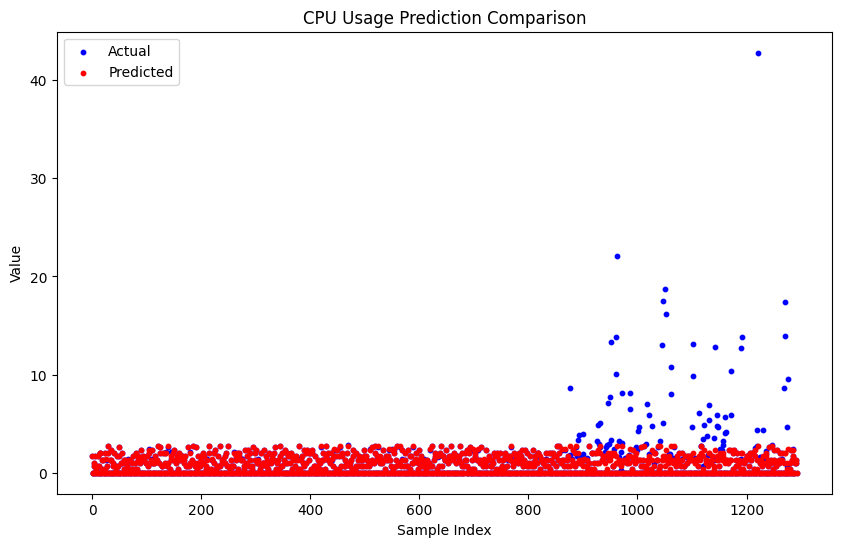

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def ensure_1d_array(data):
    """
    Ensure the data is a 1-dimensional numpy array.
    
    This function checks if the input data is a pandas DataFrame or Series, 
    or a numpy ndarray, and then converts it to a 1-dimensional numpy array.
    """
    if isinstance(data, pd.DataFrame):
        # If the DataFrame has more than one column, raise an error
        if data.shape[1] != 1:
            raise ValueError("DataFrame must have exactly one column.")
        data = data.iloc[:, 0].values  # Convert the single column to a numpy array
    elif isinstance(data, pd.Series):
        data = data.values
    elif isinstance(data, np.ndarray) and data.ndim == 2 and data.shape[1] == 1:
        data = data.flatten()
    
    # Check if the data is still not 1-dimensional
    if not isinstance(data, np.ndarray) or data.ndim != 1:
        raise ValueError("Data could not be converted to a 1-dimensional array.")
    
    return data

def plot_comparison(y_test, y_pred, title=''):
    # Ensure the data is 1-dimensional
    y_test = ensure_1d_array(y_test)
    y_pred = ensure_1d_array(y_pred)
    
    # Create a DataFrame for easier plotting
    df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_comparison = df_comparison.reset_index(drop=True)
    
    # Plotting
    # plt.figure(figsize=(10, 6))
    # plt.plot(df_comparison.index, df_comparison['Actual'], label='Actual', marker='o', linestyle='-', markersize=5)
    # plt.plot(df_comparison.index, df_comparison['Predicted'], label='Predicted', marker='x', linestyle='--', markersize=5)
    # plt.title(title)
    # plt.xlabel('Sample Index')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.show()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_comparison.index, df_comparison['Actual'], label='Actual', color='blue', s=10)
    plt.scatter(df_comparison.index, df_comparison['Predicted'], label='Predicted', color='red', s=10)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test_duration and y_pred_duration are available from previous steps, you can now call:
# plot_comparison(y_test_duration, y_pred_duration, title='Duration Prediction Comparison')
# Adjust similarly for CPU and Memory usage comparisons.

# Example usage:
# plot_comparison(y_test_duration, y_pred_duration, title='Duration Prediction Comparison')
plot_comparison(y_test_cpu_usage, y_pred_cpu, title='CPU Usage Prediction Comparison')
# plot_comparison(y_test_memory_usage, y_pred_memory, title='Memory Usage Prediction Comparison')


In [24]:
#top 10 MAX CPU USAGE
top_10_cpu = df.nlargest(10, 'Max CPU Usage')
top_10_cpu

,Unique DAG ID,DAG Input,Function Name,Input Feature,Duration,Parallel Duration,Memory_Allocated,CPU_Allocated,Max Memory Usage,Max CPU Usage,Start Time,End Time,Timeout Status
2421,AS-89856fbd-5c08-4293-8041-4a535fa9e7a5,0.010530,AES3,0.022611,57025,57025.0,256,8,40.517632,42.793045,1711185923965,1711185980990,False
2162,AS-d9206828-ed6e-4f76-a61c-d8839c554a32,0.012650,AES3,0.022600,41703,41703.0,256,8,42.844160,22.128112,1711183541256,1711183582959,False
2251,AS-58419984-6090-4129-bbe5-208bbe777543,0.010996,AES2,0.010946,33984,46671.0,256,8,30.015488,18.754891,1711184317176,1711184351160,False
2247,AS-2b24b0f1-6a65-4621-a757-0084dd33c3e5,0.009488,AES3,0.013598,73328,73328.0,256,8,34.914304,17.514308,1711184239295,1711184312623,False
2471,AS-0ec8b6d8-ecfc-48c6-93a2-97047d234b23,0.011472,AES3,0.016585,51150,51150.0,256,8,37.867520,17.438479,1711186244904,1711186296054,False
2252,AS-58419984-6090-4129-bbe5-208bbe777543,0.010996,AES3,0.019592,46671,46671.0,256,8,40.054784,16.182784,1711184317341,1711184364012,False
2470,AS-0ec8b6d8-ecfc-48c6-93a2-97047d234b23,0.011472,AES2,0.013427,40238,51150.0,256,8,32.378880,13.942164,1711186244532,1711186284770,False
2391,AS-3b99e133-89b1-4b4c-9115-a93aa6ee695d,0.010190,AES3,0.016606,72589,72589.0,256,8,32.722944,13.832137,1711185681252,1711185753841,False
2161,AS-d9206828-ed6e-4f76-a61c-d8839c554a32,0.012650,AES2,0.010946,29745,41703.0,256,8,29.761536,13.824000,1711183541487,1711183571232,False
2152,AS-62550717-6dd2-4edf-b31e-500884712568,0.011297,AES3,0.016585,39980,39980.0,256,8,36.859904,13.363314,1711183480916,1711183520896,False


In [25]:

usage = ensure_1d_array(y_test_cpu_usage)
prediction = ensure_1d_array(y_pred_cpu)
#contact usage and prediction
usage_prediction = np.column_stack((usage, prediction))
usage_prediction_df = pd.DataFrame(usage_prediction, columns=['Actual', 'Predicted'])
usage_prediction_df

,Actual,Predicted
0,1.690331,1.738546
1,0.004794,0.005705
2,0.012766,0.012811
3,0.660924,0.669160
4,1.003271,1.006774
...,...,...
1288,0.019831,0.012811
1289,0.997153,0.995730
1290,0.999917,1.006774
1291,1.335724,1.337202


   Function Name_AES1  Function Name_AES2  Function Name_AES3  \
0                 0.0                 0.0                 0.0   
1                 1.0                 0.0                 0.0   
2                 0.0                 1.0                 0.0   
3                 0.0                 0.0                 1.0   
4                 0.0                 0.0                 0.0   

   Function Name_Stats  Function Name_wait1  Input Feature  
0                  0.0                  1.0            NaN  
1                  0.0                  0.0       0.006380  
2                  0.0                  0.0       0.003523  
3                  0.0                  0.0       0.016606  
4                  1.0                  0.0            NaN  


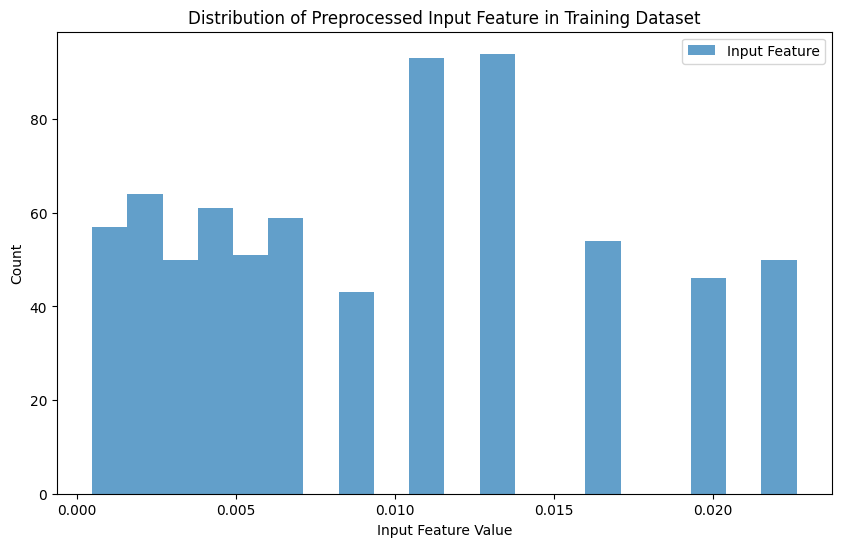

In [5]:
# View first few rows
print(X_train.head())

# Plot distributions of a specific feature
plt.figure(figsize=(10, 6))
plt.hist(X_train['Input Feature'], bins=20, alpha=0.7, label='Input Feature')
plt.title('Distribution of Preprocessed Input Feature in Training Dataset')
plt.xlabel('Input Feature Value')
plt.ylabel('Count')
plt.legend()
plt.show()


In [26]:
def calculate_cpu_usage_error_rate(y_actual, y_predicted):
    """
    Calculate the error rate for CPU usage predictions based on the criteria:
    If the predicted value falls in the integer range of the actual value, then it is not an error.
    
    Args:
        y_actual (array-like): The actual CPU usage values.
        y_predicted (array-like): The predicted CPU usage values.
        
    Returns:
        float: The error rate.
    """
    errors = 0
    for actual, predicted in zip(y_actual, y_predicted):
        # Check if predicted falls outside the integer range of actual
        if not (int(actual) <= predicted < int(actual) + 1):
            errors += 1
    
    error_rate = errors / len(y_actual)
    return error_rate


In [28]:
# Ensure y_test_cpu_usage and y_pred_cpu are 1-dimensional numpy arrays
y_test_cpu_usage = ensure_1d_array(y_test_cpu_usage)
y_pred_cpu = ensure_1d_array(y_pred_cpu)

# Calculate the error rate
cpu_usage_error_rate = calculate_cpu_usage_error_rate(y_test_cpu_usage, y_pred_cpu)

print(f"CPU Usage Error Rate: {cpu_usage_error_rate:.2%}")


CPU Usage Error Rate: 10.36%


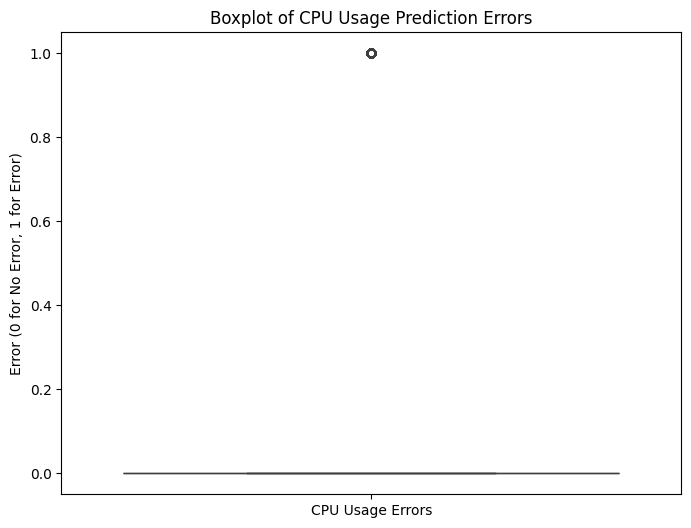

CPU Usage Error Rate: 10.36%


In [29]:
def compute_cpu_usage_errors(y_actual, y_predicted):
    """
    Compute individual errors for CPU usage predictions and the error rate.
    
    Args:
        y_actual (array-like): The actual CPU usage values.
        y_predicted (array-like): The predicted CPU usage values.
        
    Returns:
        errors (list): A list of errors (0 for no error, 1 for error) for each data point.
        float: The error rate.
    """
    errors = []
    for actual, predicted in zip(y_actual, y_predicted):
        # Error is 0 if predicted is within the integer range of actual, 1 otherwise
        error = 0 if int(actual) <= predicted < int(actual) + 1 else 1
        errors.append(error)
    
    error_rate = sum(errors) / len(y_actual)
    return errors, error_rate

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test_cpu_usage and y_pred_cpu are available from your model's predictions

# Compute errors and error rate
cpu_usage_errors, cpu_usage_error_rate = compute_cpu_usage_errors(y_test_cpu_usage, y_pred_cpu)

# Plot the boxplot of errors
plt.figure(figsize=(8, 6))
sns.boxplot(data=cpu_usage_errors)
plt.title('Boxplot of CPU Usage Prediction Errors')
plt.ylabel('Error (0 for No Error, 1 for Error)')
plt.xticks([0], ['CPU Usage Errors'])  # Adjust x-ticks for clarity
plt.show()

# Optionally, print the error rate as well
print(f"CPU Usage Error Rate: {cpu_usage_error_rate:.2%}")
